# Desafio de precificação de imóvel

O Objetivo desse notebook é criar um modelo de Machine Learning de precificação de imoveis baseado no conjunto de dados
disponibilizado pela empresa Keycash em seu Desafio de estágio de Ciencia de Dados de 2021

# Entendendo os dados do conjunto 

# Importando as bibliotecas necessarias

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Analise exploratoria dos dados do Dataset
Essa etapa consiste em verificar os detalhes dos dados e ver alguns parametros estatisticos entre as variaveis numericas do conjunto


In [7]:
data = pd.read_csv("./Desafio2_input.csv", sep=";")

data.head()

,Id,Zona,Area,Qualidade,AnoConstrucao,QualidadeAquecimento,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000


In [8]:
#verifico os tipos de cada coluna e a quantidade de elementos nulos(caso exista)
data.info()
data.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Id                    629 non-null    int64
 1   Zona                  629 non-null    str  
 2   Area                  629 non-null    int64
 3   Qualidade             629 non-null    int64
 4   AnoConstrucao         629 non-null    int64
 5   QualidadeAquecimento  629 non-null    str  
 6   Banheiros             629 non-null    int64
 7   Quartos_t1            629 non-null    int64
 8   Quartos_t2            629 non-null    int64
 9   Comodos               629 non-null    int64
 10  Lareiras              629 non-null    int64
 11  Garagem               629 non-null    int64
 12  Preco                 629 non-null    int64
dtypes: int64(11), str(2)
memory usage: 64.0 KB


Id                      0
Zona                    0
Area                    0
Qualidade               0
AnoConstrucao           0
QualidadeAquecimento    0
Banheiros               0
Quartos_t1              0
Quartos_t2              0
Comodos                 0
Lareiras                0
Garagem                 0
Preco                   0
dtype: int64

In [9]:
data.describe()

,Id,Area,Qualidade,AnoConstrucao,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,8932.025437,5.642289,1974.421304,1.370429,2.651828,3.651828,5.782194,0.515103,1.608903,148234.538951
std,181.72094,3318.885535,0.892748,19.189939,0.483304,0.551129,0.551129,1.039936,0.601361,0.577980,28088.037518
min,1.00000,1300.000000,4.000000,1940.000000,1.000000,1.000000,2.000000,3.000000,0.000000,0.000000,80000.000000
25%,158.00000,7420.000000,5.000000,1959.000000,1.000000,2.000000,3.000000,5.000000,0.000000,1.000000,129000.000000
50%,315.00000,9000.000000,6.000000,1971.000000,1.000000,3.000000,4.000000,6.000000,0.000000,2.000000,147000.000000
75%,472.00000,10530.000000,6.000000,1993.000000,2.000000,3.000000,4.000000,6.000000,1.000000,2.000000,173000.000000
max,629.00000,19900.000000,8.000000,2009.000000,2.000000,3.000000,4.000000,8.000000,2.000000,3.000000,200000.000000


C:\Users\caiom\AppData\Local\Temp\ipykernel_11284\810172127.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Preco'], bins=30)


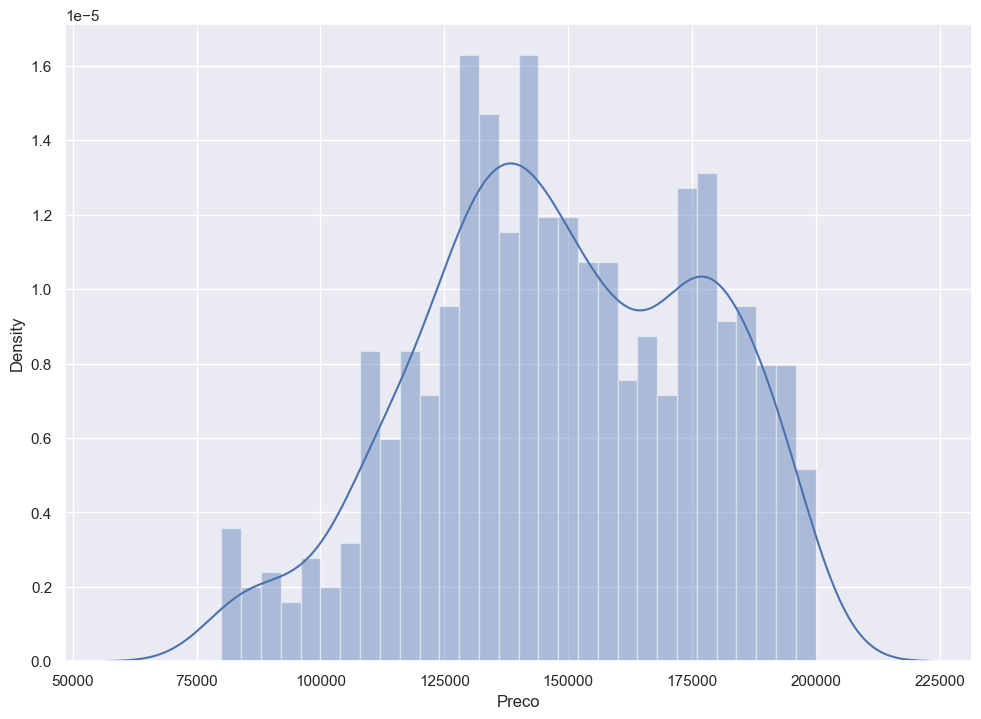

In [10]:
#visualizo a distribuição do preço
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data['Preco'], bins=30)
plt.show()

# Feature engineering
Nessa etapa é tratado os dados para verificar quais possuem uma maior relação com a variavel preço, assim definindo as features do modelo

In [14]:
#separo as variaveis categoricas, aplicoo One-Hot-Encoding e concateno em um novo dataframe
array_categorical = ['Zona','QualidadeAquecimento']
categ_df = data[array_categorical]


categorical = pd.get_dummies(categ_df, prefix=['Zona','QualidadeAquecimento'])
df_OHS = pd.concat([data, categorical], axis=1)
df_OHS.head()

,Id,Zona,Area,Qualidade,AnoConstrucao,QualidadeAquecimento,Banheiros,Quartos_t1,Quartos_t2,Comodos,Lareiras,Garagem,Preco,Zona_RL,Zona_RM,QualidadeAquecimento_Ex,QualidadeAquecimento_Fa,QualidadeAquecimento_Gd,QualidadeAquecimento_TA
0,1,RL,9600,6,1976,Ex,2,3,4,6,1,2,181500,True,False,True,False,False,False
1,2,RL,14115,5,1993,Ex,1,1,2,5,0,2,143000,True,False,True,False,False,False
2,3,RL,11200,5,1965,Ex,1,3,4,5,0,1,129500,True,False,True,False,False,False
3,4,RL,12968,5,1962,TA,1,2,3,4,0,1,144000,True,False,False,False,False,True
4,5,RL,10920,6,1960,TA,1,2,3,5,1,1,157000,True,False,False,False,False,True


Ao aplicar o One-Hot-Encondig, verifico quais as features possuem uma maior correlação com a variavel preço

<Axes: >

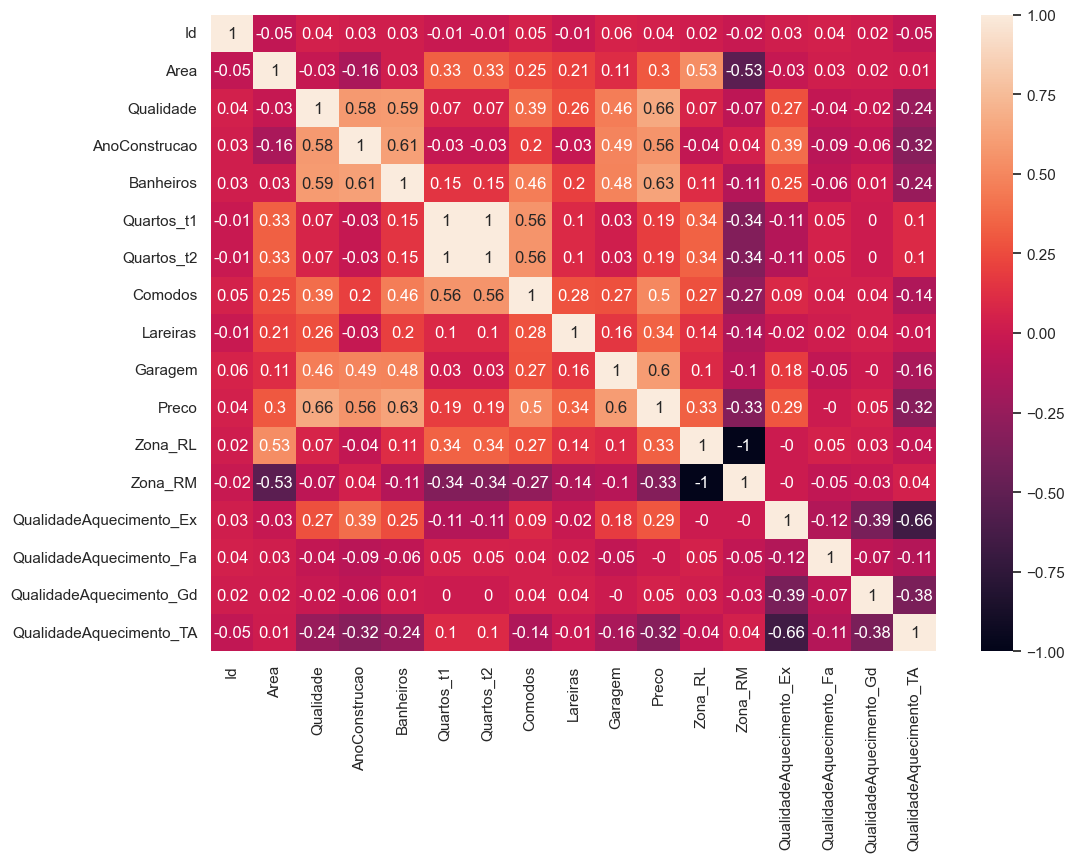

In [21]:
#mapa de calor com os dados da matriz correlacional
correlation_matrix = df_OHS.select_dtypes(include=["number", "bool"]).corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Ao analisar o mapa de calor e a tabela de matriz correlacional, são definidos as features que possuem uma relação mais forte com a variavel Preço, sendo escolhidas somente as que possuem um valor igual ou maior a 0.5. Em sequencia é analisado a dispersão dos dados de acordo com as features escolhidas

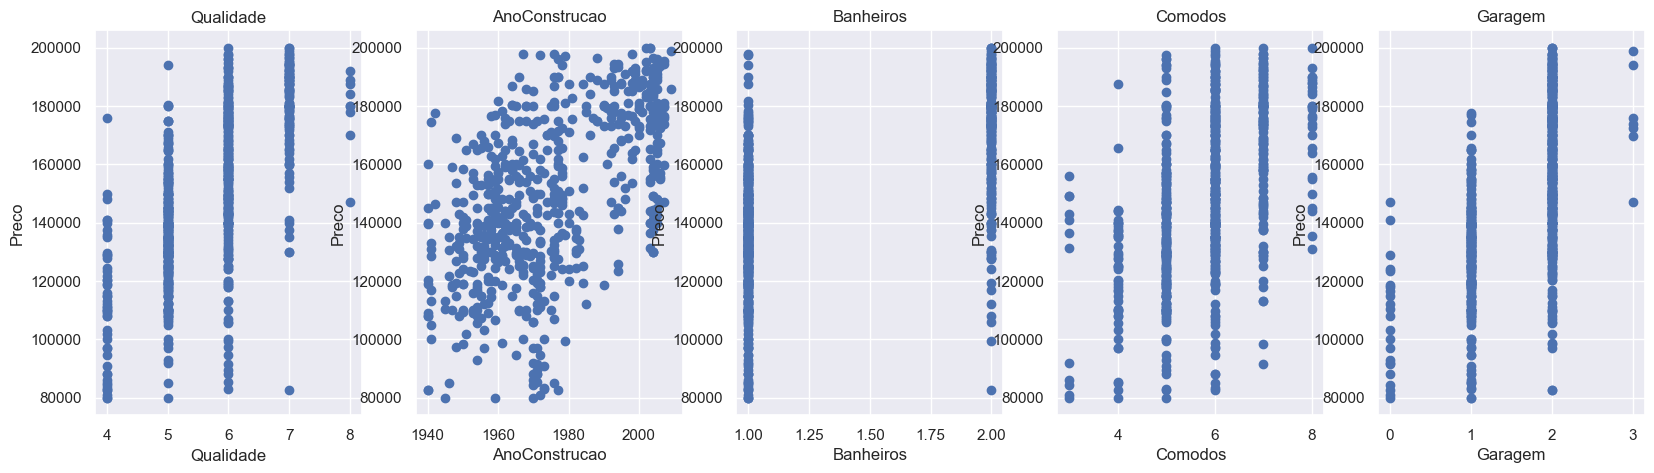

In [22]:
#verifico a dispersão de dados de acordo com as features escolhidas 
features = ['Qualidade', 'AnoConstrucao', 'Banheiros', 'Comodos', 'Garagem']
target = data['Preco']
plt.figure(figsize=(20, 5))

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = data[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Preco')

# Criação do modelo de Machine learning
Para a criação do modelo de machine learning , será utilizado a analise de regressão, onde será aplicado a regressão linear multipla, onde o valor da variavel preço é influenciada por diversas variaveis

In [ ]:
#removo as colunas que não serão utilizadas para a criação do modelo
data_features = data.drop(columns=['Id', 'Area', 'Zona', 'QualidadeAquecimento', 'Lareiras', 'Quartos_t1', 'Quartos_t2', 'Preco'])
data_features


,Qualidade,AnoConstrucao,Banheiros,Comodos,Garagem
0,6,1976,2,6,2
1,5,1993,1,5,2
2,5,1965,1,5,1
3,5,1962,1,4,1
4,6,1960,1,5,1
...,...,...,...,...,...
624,6,1966,1,6,1
625,5,1970,1,3,0
626,5,2005,1,5,2
627,6,1999,2,7,2


In [24]:
#divido meu conjunto de dados 
X_train, X_test, Y_train, Y_test = train_test_split(data_features, target, test_size = 0.2, random_state=5)

#crio o modelo
reg = LinearRegression()
reg.fit(X_train, Y_train)
print("O modelo:Vendas = {:.5} + {:.5}*Qualidade+ {:.5}*AnoConstrucao + {:.5}*Banheiros + {:.5}*Comodos + {:.5}*Garagem".format(reg.intercept_, reg.coef_[0], reg.coef_[1], reg.coef_[2], reg.coef_[3], reg.coef_[4]))

O modelo:Vendas = -3.517e+05 + 9049.0*Qualidade+ 192.04*AnoConstrucao + 7414.9*Banheiros + 6839.1*Comodos + 1.2802e+04*Garagem


In [25]:
#verifico o score do modelo passando os dados de teste
reg.score(X_test, Y_test)

0.5807188940088213

In [26]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


y_train_predict = reg.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("Performance do modelo para o conjunto de treino")
print("--------------------------------------")
print('RMSE: {}'.format(rmse))
print('R2 score:  {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = reg.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("Performance do modelo para o conjunto de teste")
print("--------------------------------------")
print('RMSE:  {}'.format(rmse))

Performance do modelo para o conjunto de treino
--------------------------------------
RMSE: 17095.609522828225
R2 score:  0.6325238473878895


Performance do modelo para o conjunto de teste
--------------------------------------
RMSE:  17761.22815639262


In [27]:
#sumario dos  dados estatisticos do modelo
array_features = np.column_stack((X_train['Qualidade'], X_train['AnoConstrucao'], X_train['Banheiros'],X_train['Comodos'], X_train['Garagem']))
X = sm.add_constant(array_features)
est = sm.OLS(Y_train, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     171.1
Date:                Mon, 16 Feb 2026   Prob (F-statistic):          1.37e-105
Time:                        19:52:05   Log-Likelihood:                -5616.3
No. Observations:                 503   AIC:                         1.124e+04
Df Residuals:                     497   BIC:                         1.127e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.517e+05   1.12e+05     -3.139      0.0

In [28]:
#criação do modelo em disco
joblib.dump(reg, 'model')

['model']

## Randoom Forest 
- A titulo de comparação, também será realizado o treinamento de um modelo Random Forest

In [32]:
data.columns

Index(['Id', 'Zona', 'Area', 'Qualidade', 'AnoConstrucao',
       'QualidadeAquecimento', 'Banheiros', 'Quartos_t1', 'Quartos_t2',
       'Comodos', 'Lareiras', 'Garagem', 'Preco'],
      dtype='str')

In [ ]:
y = data["Preco"] 
X = data.drop(columns=["Preco"])

In [34]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns


C:\Users\caiom\AppData\Local\Temp\ipykernel_11284\1942244629.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include=["object"]).columns


- Apesar do Random Forest não exigir normalização, é necessário realizar o tratamento dos categoricos 

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

In [36]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

In [37]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [39]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [40]:
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.7643
MAE: 10712.74
RMSE: 14322.20
